The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
!pip install d2l==1.0.3


# Linear Regression Implementation from Scratch
:label:`sec_linear_scratch`

We are now ready to work through
a fully functioning implementation
of linear regression.
In this section,
(**we will implement the entire method from scratch,
including (i) the model; (ii) the loss function;
(iii) a minibatch stochastic gradient descent optimizer;
and (iv) the training function
that stitches all of these pieces together.**)
Finally, we will run our synthetic data generator
from :numref:`sec_synthetic-regression-data`
and apply our model
on the resulting dataset.
While modern deep learning frameworks
can automate nearly all of this work,
implementing things from scratch is the only way
to make sure that you really know what you are doing.
Moreover, when it is time to customize models,
defining our own layers or loss functions,
understanding how things work under the hood will prove handy.
In this section, we will rely only
on tensors and automatic differentiation.
Later, we will introduce a more concise implementation,
taking advantage of the bells and whistles of deep learning frameworks
while retaining the structure of what follows below.


In [3]:
%matplotlib inline
import torch
from d2l import torch as d2l

## Defining the Model

[**Before we can begin optimizing our model's parameters**] by minibatch SGD,
(**we need to have some parameters in the first place.**)
In the following we initialize weights by drawing
random numbers from a normal distribution with mean 0
and a standard deviation of 0.01.
The magic number 0.01 often works well in practice,
but you can specify a different value
through the argument `sigma`.
Moreover we set the bias to 0.
Note that for object-oriented design
we add the code to the `__init__` method of a subclass of `d2l.Module` (introduced in :numref:`subsec_oo-design-models`).


In [4]:
class LinearRegressionScratch(d2l.Module):
    """The linear regression model implemented from scratch."""
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)

Next we must [**define our model,
relating its input and parameters to its output.**]
Using the same notation as :eqref:`eq_linreg-y-vec`
for our linear model we simply take the matrix--vector product
of the input features $\mathbf{X}$
and the model weights $\mathbf{w}$,
and add the offset $b$ to each example.
The product $\mathbf{Xw}$ is a vector and $b$ is a scalar.
Because of the broadcasting mechanism
(see :numref:`subsec_broadcasting`),
when we add a vector and a scalar,
the scalar is added to each component of the vector.
The resulting `forward` method
is registered in the `LinearRegressionScratch` class
via `add_to_class` (introduced in :numref:`oo-design-utilities`).


In [5]:
@d2l.add_to_class(LinearRegressionScratch)
def forward(self, X):
    return torch.matmul(X, self.w) + self.b

## Defining the Loss Function

Since [**updating our model requires taking
the gradient of our loss function,**]
we ought to (**define the loss function first.**)
Here we use the squared loss function
in :eqref:`eq_mse`.
In the implementation, we need to transform the true value `y`
into the predicted value's shape `y_hat`.
The result returned by the following method
will also have the same shape as `y_hat`.
We also return the averaged loss value
among all examples in the minibatch.


In [6]:
@d2l.add_to_class(LinearRegressionScratch)
def loss(self, y_hat, y):
    l = (y_hat - y) ** 2 / 2
    return l.mean()

## Defining the Optimization Algorithm

As discussed in :numref:`sec_linear_regression`,
linear regression has a closed-form solution.
However, our goal here is to illustrate
how to train more general neural networks,
and that requires that we teach you
how to use minibatch SGD.
Hence we will take this opportunity
to introduce your first working example of SGD.
At each step, using a minibatch
randomly drawn from our dataset,
we estimate the gradient of the loss
with respect to the parameters.
Next, we update the parameters
in the direction that may reduce the loss.

The following code applies the update,
given a set of parameters, a learning rate `lr`.
Since our loss is computed as an average over the minibatch,
we do not need to adjust the learning rate against the batch size.
In later chapters we will investigate
how learning rates should be adjusted
for very large minibatches as they arise
in distributed large-scale learning.
For now, we can ignore this dependency.


We define our `SGD` class,
a subclass of `d2l.HyperParameters` (introduced in :numref:`oo-design-utilities`),
to have a similar API
as the built-in SGD optimizer.
We update the parameters in the `step` method.
The `zero_grad` method sets all gradients to 0,
which must be run before a backpropagation step.


In [7]:
class SGD(d2l.HyperParameters):
    """Minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self):
        for param in self.params:
            param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

We next define the `configure_optimizers` method, which returns an instance of the `SGD` class.


In [8]:
@d2l.add_to_class(LinearRegressionScratch)
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

## Training

Now that we have all of the parts in place
(parameters, loss function, model, and optimizer),
we are ready to [**implement the main training loop.**]
It is crucial that you understand this code fully
since you will employ similar training loops
for every other deep learning model
covered in this book.
In each *epoch*, we iterate through
the entire training dataset,
passing once through every example
(assuming that the number of examples
is divisible by the batch size).
In each *iteration*, we grab a minibatch of training examples,
and compute its loss through the model's `training_step` method.
Then we compute the gradients with respect to each parameter.
Finally, we will call the optimization algorithm
to update the model parameters.
In summary, we will execute the following loop:

* Initialize parameters $(\mathbf{w}, b)$
* Repeat until done
    * Compute gradient $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * Update parameters $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

Recall that the synthetic regression dataset
that we generated in :numref:``sec_synthetic-regression-data``
does not provide a validation dataset.
In most cases, however,
we will want a validation dataset
to measure our model quality.
Here we pass the validation dataloader
once in each epoch to measure the model performance.
Following our object-oriented design,
the `prepare_batch` and `fit_epoch` methods
are registered in the `d2l.Trainer` class
(introduced in :numref:`oo-design-training`).


In [9]:
@d2l.add_to_class(d2l.Trainer)
def prepare_batch(self, batch):
    return batch

In [10]:
@d2l.add_to_class(d2l.Trainer)
def fit_epoch(self):
    self.model.train()
    for batch in self.train_dataloader:
        loss = self.model.training_step(self.prepare_batch(batch))
        self.optim.zero_grad()
        with torch.no_grad():
            loss.backward()
            if self.gradient_clip_val > 0:  # To be discussed later
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    self.model.eval()
    for batch in self.val_dataloader:
        with torch.no_grad():
            self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1

We are almost ready to train the model,
but first we need some training data.
Here we use the `SyntheticRegressionData` class
and pass in some ground truth parameters.
Then we train our model with
the learning rate `lr=0.03`
and set `max_epochs=3`.
Note that in general, both the number of epochs
and the learning rate are hyperparameters.
In general, setting hyperparameters is tricky
and we will usually want to use a three-way split,
one set for training,
a second for hyperparameter selection,
and the third reserved for the final evaluation.
We elide these details for now but will revise them
later.


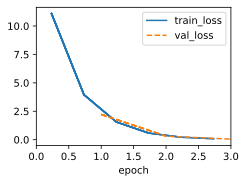

In [11]:
model = LinearRegressionScratch(2, lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

Because we synthesized the dataset ourselves,
we know precisely what the true parameters are.
Thus, we can [**evaluate our success in training
by comparing the true parameters
with those that we learned**] through our training loop.
Indeed they turn out to be very close to each other.


In [12]:
with torch.no_grad():
    print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'error in estimating b: {data.b - model.b}')

error in estimating w: tensor([ 0.1088, -0.1915])
error in estimating b: tensor([0.2182])


We should not take the ability to exactly recover
the ground truth parameters for granted.
In general, for deep models unique solutions
for the parameters do not exist,
and even for linear models,
exactly recovering the parameters
is only possible when no feature
is linearly dependent on the others.
However, in machine learning,
we are often less concerned
with recovering true underlying parameters,
but rather with parameters
that lead to highly accurate prediction :cite:`Vapnik.1992`.
Fortunately, even on difficult optimization problems,
stochastic gradient descent can often find remarkably good solutions,
owing partly to the fact that, for deep networks,
there exist many configurations of the parameters
that lead to highly accurate prediction.


## Summary

In this section, we took a significant step
towards designing deep learning systems
by implementing a fully functional
neural network model and training loop.
In this process, we built a data loader,
a model, a loss function, an optimization procedure,
and a visualization and monitoring tool.
We did this by composing a Python object
that contains all relevant components for training a model.
While this is not yet a professional-grade implementation
it is perfectly functional and code like this
could already help you to solve small problems quickly.
In the coming sections, we will see how to do this
both *more concisely* (avoiding boilerplate code)
and *more efficiently* (using our GPUs to their full potential).



## Exercises

1. What would happen if we were to initialize the weights to zero. Would the algorithm still work? What if we
   initialized the parameters with variance $1000$ rather than $0.01$?
1. Assume that you are [Georg Simon Ohm](https://en.wikipedia.org/wiki/Georg_Ohm) trying to come up
   with a model for resistance that relates voltage and current. Can you use automatic
   differentiation to learn the parameters of your model?
1. Can you use [Planck's Law](https://en.wikipedia.org/wiki/Planck%27s_law) to determine the temperature of an object
   using spectral energy density? For reference, the spectral density $B$ of radiation emanating from a black body is
   $B(\lambda, T) = \frac{2 hc^2}{\lambda^5} \cdot \left(\exp \frac{h c}{\lambda k T} - 1\right)^{-1}$. Here
   $\lambda$ is the wavelength, $T$ is the temperature, $c$ is the speed of light, $h$ is Planck's constant, and $k$ is the
   Boltzmann constant. You measure the energy for different wavelengths $\lambda$ and you now need to fit the spectral
   density curve to Planck's law.
1. What are the problems you might encounter if you wanted to compute the second derivatives of the loss? How would
   you fix them?
1. Why is the `reshape` method needed in the `loss` function?
1. Experiment using different learning rates to find out how quickly the loss function value drops. Can you reduce the
   error by increasing the number of epochs of training?
1. If the number of examples cannot be divided by the batch size, what happens to `data_iter` at the end of an epoch?
1. Try implementing a different loss function, such as the absolute value loss `(y_hat - d2l.reshape(y, y_hat.shape)).abs().sum()`.
    1. Check what happens for regular data.
    1. Check whether there is a difference in behavior if you actively perturb some entries, such as $y_5 = 10000$, of $\mathbf{y}$.
    1. Can you think of a cheap solution for combining the best aspects of squared loss and absolute value loss?
       Hint: how can you avoid really large gradient values?
1. Why do we need to reshuffle the dataset? Can you design a case where a maliciously constructed dataset would break the optimization algorithm otherwise?


[Discussions](https://discuss.d2l.ai/t/43)


1. 权重初始化为零或大方差的影响

In [13]:
import torch
import torch.nn as nn

# 简单线性模型
class SimpleLinear(nn.Module):
    def __init__(self):
        super(SimpleLinear, self).__init__()
        self.linear = nn.Linear(1, 1)
        # 将权重初始化为0
        self.linear.weight.data.fill_(0)
        self.linear.bias.data.fill_(0)

    def forward(self, x):
        return self.linear(x)

model = SimpleLinear()
x = torch.tensor([[1.0]])
y = torch.tensor([[2.0]])

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

for epoch in range(10):
    y_hat = model(x)
    loss = criterion(y_hat, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

Epoch 1, Loss: 4.0
Epoch 2, Loss: 3.6863999366760254
Epoch 3, Loss: 3.397386074066162
Epoch 4, Loss: 3.1310312747955322
Epoch 5, Loss: 2.8855583667755127
Epoch 6, Loss: 2.6593306064605713
Epoch 7, Loss: 2.4508392810821533
Epoch 8, Loss: 2.2586934566497803
Epoch 9, Loss: 2.0816118717193604
Epoch 10, Loss: 1.9184131622314453


2. 用自动微分学习电阻模型参数

In [14]:
import torch
import numpy as np

# 生成模拟数据
np.random.seed(0)
num_samples = 100
I = np.random.randn(num_samples, 1).astype(np.float32)
R_true = 2.0
V = I * R_true

I_tensor = torch.from_numpy(I)
V_tensor = torch.from_numpy(V)

# 构建模型
class ResistanceModel(nn.Module):
    def __init__(self):
        super(ResistanceModel, self).__init__()
        self.R = nn.Parameter(torch.tensor([1.0]))

    def forward(self, i):
        return self.R * i

model = ResistanceModel()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

for epoch in range(100):
    V_hat = model(I_tensor)
    loss = criterion(V_hat, V_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch + 1}, Loss: {loss.item()}, R: {model.R.item()}')

Epoch 1, Loss: 1.0194035768508911, R: 1.020388126373291
Epoch 11, Loss: 0.6751920580863953, R: 1.2027498483657837
Epoch 21, Loss: 0.4472070336341858, R: 1.351163387298584
Epoch 31, Loss: 0.2962034344673157, R: 1.4719488620758057
Epoch 41, Loss: 0.19618764519691467, R: 1.570249080657959
Epoch 51, Loss: 0.12994295358657837, R: 1.6502503156661987
Epoch 61, Loss: 0.08606644719839096, R: 1.7153587341308594
Epoch 71, Loss: 0.05700530484318733, R: 1.7683466672897339
Epoch 81, Loss: 0.037756890058517456, R: 1.811470627784729
Epoch 91, Loss: 0.025007929652929306, R: 1.8465665578842163


3. 用普朗克定律确定物体温度

In [15]:
import torch
import numpy as np

# 常量定义
h = 6.62607015e-34  # 普朗克常数
c = 299792458  # 光速
k = 1.380649e-23  # 玻尔兹曼常数

# 模拟波长和测量的光谱能量密度数据
np.random.seed(0)
num_samples = 50
lambda_ = np.random.rand(num_samples, 1).astype(np.float32) * 1e-6
T_true = 1000  # 真实温度
B_true = (2 * h * c ** 2 / lambda_ ** 5) * (1 / (np.exp(h * c / (lambda_ * k * T_true)) - 1))

lambda_tensor = torch.from_numpy(lambda_)
B_true_tensor = torch.from_numpy(B_true)

# 构建模型
class TemperatureModel(nn.Module):
    def __init__(self):
        super(TemperatureModel, self).__init__()
        self.T = nn.Parameter(torch.tensor([1.0]))

    def forward(self, lambda_):
        return (2 * h * c ** 2 / lambda_ ** 5) * (1 / (torch.exp(h * c / (lambda_ * k * self.T)) - 1))

model = TemperatureModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(200):
    B_hat = model(lambda_tensor)
    loss = criterion(B_hat, B_true_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print(f'Epoch {epoch + 1}, Loss: {loss.item()}, T: {model.T.item()}')

<ipython-input-15-9a6dd0e20e3a>:14: RuntimeWarning: overflow encountered in exp
  B_true = (2 * h * c ** 2 / lambda_ ** 5) * (1 / (np.exp(h * c / (lambda_ * k * T_true)) - 1))


Epoch 1, Loss: nan, T: nan
Epoch 21, Loss: nan, T: nan
Epoch 41, Loss: nan, T: nan
Epoch 61, Loss: nan, T: nan
Epoch 81, Loss: nan, T: nan
Epoch 101, Loss: nan, T: nan
Epoch 121, Loss: nan, T: nan
Epoch 141, Loss: nan, T: nan
Epoch 161, Loss: nan, T: nan
Epoch 181, Loss: nan, T: nan


4. 计算损失函数二阶导数的问题及解决方法
问题：计算损失函数二阶导数（海森矩阵）计算量巨大，对于大规模神经网络，存储海森矩阵需要大量内存，且计算过程耗时。此外，海森矩阵可能病态（条件数很大），导致数值不稳定，影响后续基于二阶导数的优化算法（如牛顿法）的准确性和收敛性。
解决方法：可以使用近似海森矩阵的方法，如拟牛顿法（BFGS、L-BFGS 等），通过迭代更新近似海森矩阵的逆，减少计算量和内存需求；还可以采用随机化方法，对海森矩阵进行随机估计，降低计算复杂度。

5. 在损失函数中使用 reshape 方法的原因
理论分析：在深度学习中，模型输出（预测值）和真实标签的形状可能不一致，例如模型输出可能是二维张量（批量大小，类别数），而标签可能是一维张量（批量大小）。reshape 方法用于调整张量形状，使它们在计算损失函数时维度匹配，保证损失计算正确。例如在计算交叉熵损失时，需要将预测值和标签调整到合适形状才能进行逐元素运算。

6. 不同学习率和训练轮数对损失的影响

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# 生成模拟数据
np.random.seed(0)
num_samples = 100
x = np.random.randn(num_samples, 1).astype(np.float32)
y = 2 * x + 1 + np.random.randn(num_samples, 1).astype(np.float32) * 0.5

x_tensor = torch.from_numpy(x)
y_tensor = torch.from_numpy(y)

# 构建简单线性模型
class SimpleLinear(nn.Module):
    def __init__(self):
        super(SimpleLinear, self).__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        return self.linear(x)

model = SimpleLinear()
criterion = nn.MSELoss()

# 测试不同学习率
learning_rates = [0.01, 0.1, 1]
for lr in learning_rates:
    optimizer = optim.SGD(model.parameters(), lr=lr)
    losses = []
    for epoch in range(50):
        y_hat = model(x_tensor)
        loss = criterion(y_hat, y_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print(f'Learning rate: {lr}, Final Loss: {losses[-1]}')

# 测试增加训练轮数对误差的影响
optimizer = optim.SGD(model.parameters(), lr=0.01)
losses = []
epochs = 100
for epoch in range(epochs):
    y_hat = model(x_tensor)
    loss = criterion(y_hat, y_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
print(f'After {epochs} epochs, Final Loss: {losses[-1]}')

Learning rate: 0.01, Final Loss: 1.6264305114746094
Learning rate: 0.1, Final Loss: 0.26429295539855957
Learning rate: 1, Final Loss: 0.2643090486526489
After 100 epochs, Final Loss: 0.26429322361946106


7. 样本数不能被批量大小整除时 data_iter 的情况
理论分析：在使用数据迭代器（如 DataLoader ）时，当样本数不能被批量大小整除时，在一个训练轮次（epoch）结束时，最后一个批次的数据量会小于设定的批量大小。例如，有 103 个样本，批量大小设为 32，前 3 个批次是 32 个样本，最后一个批次是 7 个样本。这不会影响模型训练，只是在计算梯度和更新权重时，基于这个小批次进行计算。

8. 实现不同损失函数


In [17]:
import torch
import torch.nn as nn
import numpy as np

# 生成模拟数据
np.random.seed(0)
num_samples = 100
x = np.random.randn(num_samples, 1).astype(np.float32)
y = 2 * x + 1 + np.random.randn(num_samples, 1).astype(np.float32) * 0.5

x_tensor = torch.from_numpy(x)
y_tensor = torch.from_numpy(y)

# 构建简单线性模型
class SimpleLinear(nn.Module):
    def __init__(self):
        super(SimpleLinear, self).__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        return self.linear(x)

model = SimpleLinear()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# 绝对损失函数
def absolute_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)).abs().sum()

# 正常数据测试
for epoch in range(50):
    y_hat = model(x_tensor)
    loss = absolute_loss(y_hat, y_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

# 扰动数据测试
y_tensor_perturbed = y_tensor.clone()
y_tensor_perturbed[5] = 10000
for epoch in range(50):
    y_hat = model(x_tensor)
    loss = absolute_loss(y_hat, y_tensor_perturbed)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch + 1}, Loss (perturbed): {loss.item()}')

# 结合平方损失和绝对损失优点的方案
def combined_loss(y_hat, y, alpha=0.5):
    squared_loss = ((y_hat - y.reshape(y_hat.shape)) ** 2).sum()
    abs_loss = (y_hat - y.reshape(y_hat.shape)).abs().sum()
    return alpha * squared_loss + (1 - alpha) * abs_loss

for epoch in range(50):
    y_hat = model(x_tensor)
    loss = combined_loss(y_hat, y_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch + 1}, Combined Loss: {loss.item()}')

Epoch 1, Loss: 186.4241943359375
Epoch 11, Loss: 42.89008712768555
Epoch 21, Loss: 42.90993881225586
Epoch 31, Loss: 42.92979049682617
Epoch 41, Loss: 42.94965744018555
Epoch 1, Loss (perturbed): 10042.9521484375
Epoch 11, Loss (perturbed): 10042.97265625
Epoch 21, Loss (perturbed): 10042.9912109375
Epoch 31, Loss (perturbed): 10042.935546875
Epoch 41, Loss (perturbed): 10042.9580078125
Epoch 1, Combined Loss: 34.94688415527344
Epoch 11, Combined Loss: 34.83492660522461
Epoch 21, Combined Loss: 34.83492660522461
Epoch 31, Combined Loss: 34.83492660522461
Epoch 41, Combined Loss: 34.83492660522461


9. 重新打乱数据集的原因及恶意构造数据集的影响
理论分析：

重新打乱数据集原因：在训练神经网络时，重新打乱数据集可以避免模型按照某种固定顺序学习数据，防止模型捕捉到数据的顺序相关特征，而不是真正的潜在模式。例如，若数据按类别先后排序，模型可能学习到错误的类别顺序依赖，而不是类别本身的特征。打乱数据有助于模型更公平、全面地学习数据分布。
恶意构造数据集情况：若恶意构造数据集，例如将所有正样本放在前半部分，负样本放在后半部分，且模型训练时按顺序读取数据，模型可能会错误地学习到样本位置相关的 “特征”，而不是样本真实特征。在预测新数据时，由于新数据顺序不同，模型性能会大幅下降。可以通过在每个 epoch 开始时重新打乱数据来避免这种情况。